In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
import os
import random

In [5]:
PATH = "data/seedlings/"
sz=112
bs=64

In [6]:
# if not os.path.exists(f'{PATH}valid'):
#     os.makedirs(f'{PATH}valid')

# train_path=f'{PATH}train/'
# dirlist = [ item for item in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, item)) ]

# for dir_index in range(len(dirlist)):
#     if not os.path.exists(f'{PATH}valid/{dirlist[dir_index]}'):
#         os.makedirs(f'{PATH}valid/{dirlist[dir_index]}')
        
#     src_path = f'{PATH}train/{dirlist[dir_index]}/'
#     dst_path = f'{PATH}valid/{dirlist[dir_index]}/'
    
#     list_src = os.listdir(src_path)
#     number_files = len(list_src)
#     number_to_extract = int(.3 * number_files)
    
#     for file_index in range(number_to_extract):
#         random_filename = random.choice([
#             x for x in os.listdir(src_path)
#             if os.path.isfile(os.path.join(src_path, x))
#         ])
#         shutil.move(src_path + str(random_filename), dst_path + str(random_filename))
    

In [7]:
torch.cuda.is_available()

True

In [8]:
torch.backends.cudnn.enabled

True

In [9]:
os.listdir(PATH)

['zip_files',
 'train',
 'tmp',
 'test',
 'valid',
 'models',
 'sample_submission.csv']

In [10]:
os.listdir(f'{PATH}valid')

['maize',
 'common-wheat',
 'sugar-beet',
 'common-chickweed',
 'charlock',
 'shepherds-purse',
 'cleavers',
 'loose-silky-bent',
 'small-flowered-cranesbill',
 'fat-hen',
 'scentless-mayweed',
 'black-grass']

In [11]:
files = os.listdir(f'{PATH}valid/sugar-beet')[:5]
files

['e81a8dacb.png',
 '905ce5eb9.png',
 '728642410.png',
 '82b9d0a49.png',
 '88036eac5.png']

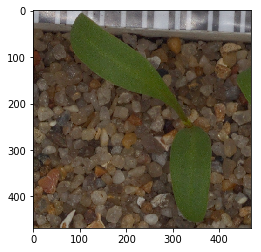

In [12]:
img = plt.imread(f'{PATH}valid/sugar-beet/{files[0]}')
plt.imshow(img);

In [13]:
img.shape

(468, 468, 3)

In [14]:
img[:4,:4]

array([[[0.75294, 0.72549, 0.7098 ],
        [0.64314, 0.61961, 0.61176],
        [0.70588, 0.69804, 0.70196],
        [0.73725, 0.73725, 0.74902]],

       [[0.7451 , 0.72157, 0.71373],
        [0.65882, 0.64314, 0.63922],
        [0.68235, 0.67451, 0.68627],
        [0.72549, 0.72941, 0.74118]],

       [[0.62745, 0.60392, 0.60784],
        [0.60392, 0.59216, 0.6    ],
        [0.6549 , 0.6549 , 0.67059],
        [0.72157, 0.72157, 0.74118]],

       [[0.51373, 0.49412, 0.5098 ],
        [0.59216, 0.58431, 0.59608],
        [0.63922, 0.63922, 0.65882],
        [0.71373, 0.71765, 0.73725]]], dtype=float32)

# 2.  Initial Model

In [15]:
arch=resnet50
data = ImageClassifierData.from_paths(PATH, bs, tfms=tfms_from_model(arch, sz), trn_name = 'train', 
                                      val_name = 'valid', test_name = 'test')

learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 50/50 [00:08<00:00,  6.17it/s]


In [16]:
learn.fit(0.01, 20)

epoch      trn_loss   val_loss   accuracy                    
    0      1.193106   0.73164    0.765493  
    1      0.841256   0.707516   0.791549                     
    2      0.756833   0.599558   0.797887                     
    3      0.594015   0.550714   0.822535                     
    4      0.525784   0.489699   0.840141                     
    5      0.523093   0.507853   0.832394                     
    6      0.496309   0.730745   0.757042                     
    7      0.501431   0.578986   0.811972                     
    8      0.340709   0.499172   0.842254                     
    9      0.352187   0.500738   0.842254                     
    10     0.321057   0.480854   0.865493                     
    11     0.338367   0.455107   0.857042                     
    12     0.345119   1.286577   0.785915                     
    13     0.307424   0.45252    0.851408                     
    14     0.276404   0.673186   0.826056                     
    15     0

[array([0.42438]), 0.877464788564494]

## Choosing a learning rate

In [17]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [24]:
lrf=learn.lr_find()

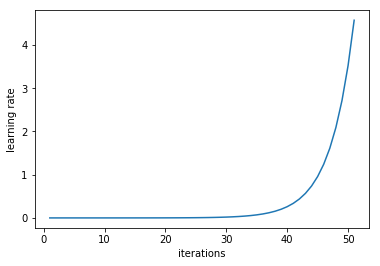

In [25]:
learn.sched.plot_lr()

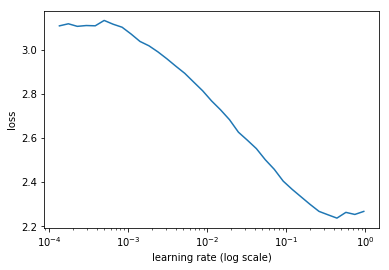

In [26]:
learn.sched.plot()

## Improving the model
### Data Augementation

In [21]:
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), trn_name = 'train', 
                                      val_name = 'valid', test_name = 'test', num_workers=4)
    
    return data if sz>300 else data.resize(340, 'tmp')

In [22]:
data = get_data(sz,bs)

In [23]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


In [27]:
learn.fit(0.1, 10)

epoch      trn_loss   val_loss   accuracy                 
    0      1.477804   1.218883   0.66831   
    1      1.25462    0.822396   0.766197                 
    2      0.955867   3.473168   0.630282                  
    3      0.940371   0.732363   0.772535                  
    4      0.866033   0.668283   0.801408                  
    5      0.770058   0.766811   0.772535                  
    6      0.868068   1.346134   0.775352                  
    7      0.772715   0.717344   0.823944                  
    8      0.745359   0.677846   0.825352                  
    9      0.722132   0.70293    0.815493                  


[array([0.70293]), 0.8154929575785784]

### Set precompute to False so that data augmentation can take effect

In [28]:
learn.precompute=False

In [29]:
learn.fit(.1, 10, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.584073   0.533665   0.859859  
    1      0.664788   0.60608    0.844366                  
    2      0.682898   0.596327   0.84507                   
    3      0.665761   0.618089   0.851408                  
    4      0.800949   0.716093   0.861972                  
    5      0.811459   0.715068   0.847183                  
    6      0.759418   0.823746   0.849296                  
    7      0.712061   0.866549   0.840141                  
    8      0.9062     0.891789   0.854225                  
    9      0.932033   0.828296   0.848592                  


[array([0.8283]), 0.8485915491278743]

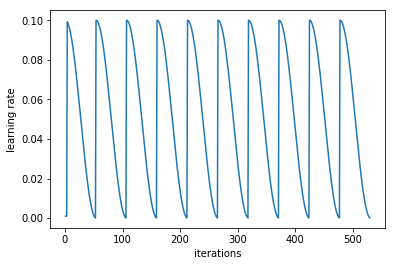

In [30]:
learn.sched.plot_lr()

In [ ]:
learn.save('224_lastlayer')

In [ ]:
learn.load('224_lastlayer')

### Fine Tuning - Unfreeze and retrain layers

In [31]:
learn.unfreeze()

In [32]:
lr=np.array([.001,.01,.1])

In [33]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

  0%|          | 0/53 [00:00<?, ?it/s]

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [ ]:
learn.save('224_all')

In [ ]:
learn.load('224_all')

### TTA - Test Time Augmentation

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [ ]:
accuracy_np(probs, y)

## Analyzing results

In [ ]:
# preds = np.argmax(probs, axis=1)
# probs = np.exp(log_preds[:,1])
# print(probs)

print(preds.shape())

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

# **Data Visualization**

In [36]:
log_preds = learn.predict()
log_preds.shape

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [ ]:
log_preds[:10]

In [35]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 11
probs = np.exp(log_preds[:,11])        # pr(Sugar beet)

NameError: name 'log_preds' is not defined

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [ ]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [ ]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [ ]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [ ]:
# This is the label for a val data
data.val_y

In [ ]:
# from here we know that 'Black-grass' is labeled 0 and 'Sugar beat' is labeled 11.
data.classes

In [ ]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [ ]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [ ]:
plot_val_with_title(most_by_correct(0, True), "Most correct Black-grass")

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect Black-grass")

In [ ]:
plot_val_with_title(most_by_correct(1, True), "Most correct Charlock")

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect Charlock")

In [ ]:
plot_val_with_title(most_by_correct(2, True), "Most correct Cleavers")

In [ ]:
plot_val_with_title(most_by_correct(2, False), "Most incorrect Cleavers")

In [ ]:
plot_val_with_title(most_by_correct(3, True), "Most correct Chickweed")

In [ ]:
plot_val_with_title(most_by_correct(3, False), "Most incorrect Chickweed")

In [ ]:
plot_val_with_title(most_by_correct(4, True), "Most correct common wheat")

In [ ]:
plot_val_with_title(most_by_correct(4, False), "Most incorrect common wheat")

In [ ]:
plot_val_with_title(most_by_correct(5, True), "Most correct Fat Hen")

In [ ]:
plot_val_with_title(most_by_correct(5, False), "Most correct Fat Hen")

In [ ]:
plot_val_with_title(most_by_correct(6, True), "Most correct loose silky-bent")

In [ ]:
plot_val_with_title(most_by_correct(6, False), "Most incorrect loose silky-bent")

In [ ]:
plot_val_with_title(most_by_correct(7, True), "Most correct Maize")

In [ ]:
plot_val_with_title(most_by_correct(7, False), "Most incorrect Maize")

In [ ]:
plot_val_with_title(most_by_correct(8, True), "Most correct scentless mayweed")

In [ ]:
plot_val_with_title(most_by_correct(8, False), "Most incorrect scentless mayweed")

In [ ]:
plot_val_with_title(most_by_correct(9, True), "Most correct shepherds purse")

In [ ]:
plot_val_with_title(most_by_correct(9, False), "Most incorrect shepherds purse")

In [ ]:
plot_val_with_title(most_by_correct(10, True), "Most correct small flowered cranesbill")

In [ ]:
plot_val_with_title(most_by_correct(10, False), "Most incorrect small flowered cranesbill")

In [ ]:
plot_val_with_title(most_by_correct(11, True), "Most correct sugar beat")

In [ ]:
plot_val_with_title(most_by_correct(11, False), "Most incorrect sugar beat")